# Forrest Cover Type Prediction

### w207 Final Project, Spring 2022

Oren Carmeli, Sam Stephens, Stephen Bridwell, Jon Hand.

# Outline

1. Introduction
2. Exploratory Data Analysis (EDA)
3. Baseline Models
4. Generalize Step Optimization 
    + feature engineering
    + hyperparameters
5. Conclusion
6. Appendix

______________________________________________________________________________________________________________________

# 1) Introduction

### Dataset

The dataset is part of a public competition on [kaggle](https://www.kaggle.com/c/forest-cover-type-prediction/data) that includes recorded attributes of four wilderness areas located in the Roosevelt National Forest of northern Colorado. Each observation (i.e record in the dataset) is a 30m x 30m patch of land. It includes 10 features in raw form (not scaled) as well as binary flags for qualitative independent variables such as wilderness areas and soil type.


### Business Problem
Understanding forest composition is a valuable aspect of managing the health and vitality of our wilderness areas. Classifying cover type can help further research regarding forest fire susceptibility, the spread of the Mountain Pine Beetle infestion, and de-reforestation concerns [[link]](http://cs229.stanford.edu/proj2014/Kevin%20Crain,%20Graham%20Davis,%20Classifying%20Forest%20Cover%20Type%20using%20Cartographic%20Features.pdf).


### Inference Problem

The inference problem is to predict the forest cover type (the predominant kind of tree cover) from strictly cartographic variables (as opposed to remotely sensed data). Specifically, our goal is to build a model that maps the cartographic variables (X) to predict a forecast cover type (Y). The data fields are defined below;

#### Data Fields (X)
- Elevation - Elevation in meters
- Aspect - Aspect in degrees azimuth
- Slope - Slope in degrees
- Horizontal_Distance_To_Hydrology - Horz Dist to nearest surface water features
- Vertical_Distance_To_Hydrology - Vert Dist to nearest surface water features
- Horizontal_Distance_To_Roadways - Horz Dist to nearest roadway
- Hillshade_9am (0 to 255 index) - Hillshade index at 9am, summer solstice
- Hillshade_Noon (0 to 255 index) - Hillshade index at noon, summer solstice
- Hillshade_3pm (0 to 255 index) - Hillshade index at 3pm, summer solstice
- Horizontal_Distance_To_Fire_Points - Horz Dist to nearest wildfire ignition points
- Wilderness_Area (4 binary columns, 0 = absence or 1 = presence) - Wilderness area designation
- Soil_Type (40 binary columns, 0 = absence or 1 = presence) - Soil Type designation

#### Data Fields (Y)
- Cover_Type (7 types, integers 1 to 7) - Forest Cover Type designation

The integer cover type value corresponds to the following names;
1. Spruce/Fir
2. Lodgepole Pine
3. Ponderosa Pine
4. Cottonwood/Willow
5. Aspen
6. Douglas-fir
7. Krummholz

# 2) Exploratory Data Analysis (EDA)

### Load Packages

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression, LinearRegression
import warnings
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
from sklearn.ensemble import  GradientBoostingClassifier
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC, LinearSVC 
from sklearn.neural_network import MLPClassifier

from sklearn import tree
from sklearn.decomposition import PCA, SparsePCA

from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import json
import pickle
from IPython.display import Image

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

k_folds = 5
%matplotlib inline

### Create Train, Dev, & Test Objects

In [2]:
np.random.seed(0)

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# load data

train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# set up modeling datasets

# X = all but last column 
X_train = np.array(train.iloc[:,:-1])
X_test = np.array(test)

# Y = last column only
Y_train = np.array(train.iloc[:,-1].tolist())

# build dev set based on random subset (20% of train data)
shuffle = np.random.permutation(np.arange(X_train.shape[0]))
X_train, Y_train = X_train[shuffle], Y_train[shuffle]

dev_size = round(X_train.shape[0] * 0.2)
dev_data, dev_labels = X_train[:dev_size], Y_train[:dev_size]
train_data, train_labels = X_train[dev_size:], Y_train[dev_size:]
test_data = X_test

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# set up dataset with cover type names for readible EDA

# append cover type labels
label_categories = ['Spruce/Fir', 
                    'Lodgepole Pine', 
                    'Ponderosa Pine', 
                    'Cottonwood/Willow', 
                    'Aspen',
                    'Douglas-fir',
                    'Krummholz']
label_categories = pd.DataFrame(data = zip(label_categories,list(range(1,8,1))), columns = ['Cover_Type_Name','Cover_Type'])
train_df = train.merge(label_categories, left_on='Cover_Type', right_on='Cover_Type')

# filter to be same subset as in train_data created above
train_df = train_df.iloc[shuffle,:].iloc[dev_size:, :]


# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# show object stats

print('Train Data shape: ', train_data.shape)
print('Train Labels shape: ', train_labels.shape)
print()
print('Dev Data shape: ', dev_data.shape)
print('Dev Labels shape: ', dev_labels.shape)
print()
print('Test Data shape: ', test_data.shape)
print()
print('Column Names: ')
print(train_df.columns)

# check dev split works
#print(f'Dev split check status: {dev_data.shape[0] + train_data.shape[0] == X_train.shape[0]}')

Train Data shape:  (12096, 55)
Train Labels shape:  (12096,)

Dev Data shape:  (3024, 55)
Dev Labels shape:  (3024,)

Test Data shape:  (565892, 55)

Column Names: 
Index(['Id', 'Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
       'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil

###  Initial Look of the Dataset

In [3]:
train_df.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type,Cover_Type_Name
7366,9214,3259,354,18,384,134,3783,186,205,155,3570,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,7,Krummholz
4936,6401,3076,123,18,134,21,3294,247,224,98,2520,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,Spruce/Fir
5777,10220,3239,359,19,570,100,2170,188,201,148,190,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,Spruce/Fir
10724,15008,2370,107,17,175,48,201,247,217,92,713,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,Ponderosa Pine
9412,5593,2365,246,27,201,85,532,156,249,223,1839,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,Ponderosa Pine


In [28]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,12096.0,7545.648479,4364.481461,1.0,3776.75,7554.0,11318.25,15120.0
Elevation,12096.0,2752.033069,417.413553,1863.0,2378.00,2756.5,3108.00,3849.0
Aspect,12096.0,155.752067,109.878900,0.0,64.00,125.0,259.00,360.0
Slope,12096.0,16.511409,8.444270,0.0,10.00,15.0,22.00,52.0
Horizontal_Distance_To_Hydrology,12096.0,229.258267,210.059941,0.0,67.00,180.0,331.00,1318.0
Vertical_Distance_To_Hydrology,12096.0,51.529431,61.497514,-146.0,5.00,33.0,80.00,554.0
Horizontal_Distance_To_Roadways,12096.0,1717.272817,1324.545866,0.0,759.00,1318.0,2280.00,6811.0
Hillshade_9am,12096.0,212.880374,30.534789,0.0,196.00,220.0,236.00,254.0
Hillshade_Noon,12096.0,218.948330,22.760152,99.0,207.00,223.0,235.00,254.0
Hillshade_3pm,12096.0,134.857474,45.854247,0.0,106.00,138.0,167.00,248.0


In [29]:
train_df.astype(bool).sum(axis=0).reset_index(name='Non-Zeros')

,index,Non-Zeros
0,Id,12096
1,Elevation,12096
2,Aspect,12007
3,Slope,12091
4,Horizontal_Distance_To_Hydrology,10851
5,Vertical_Distance_To_Hydrology,10605
6,Horizontal_Distance_To_Roadways,12094
7,Hillshade_9am,12095
8,Hillshade_Noon,12096
9,Hillshade_3pm,12025


Wilderness and soil binary flag columns appear significantly more sparse than first 10 variables. 

In [30]:
# distribution of train data labels
train_df['Cover_Type_Name'].value_counts()

Lodgepole Pine       1753
Spruce/Fir           1740
Aspen                1735
Ponderosa Pine       1729
Krummholz            1727
Cottonwood/Willow    1718
Douglas-fir          1694
Name: Cover_Type_Name, dtype: int64

There's an equal presence across all cover types. This helps confirm we will not need to do a stratified sampling for fit and generalize datasets. 

### Deeper Dive Into Feature Variables

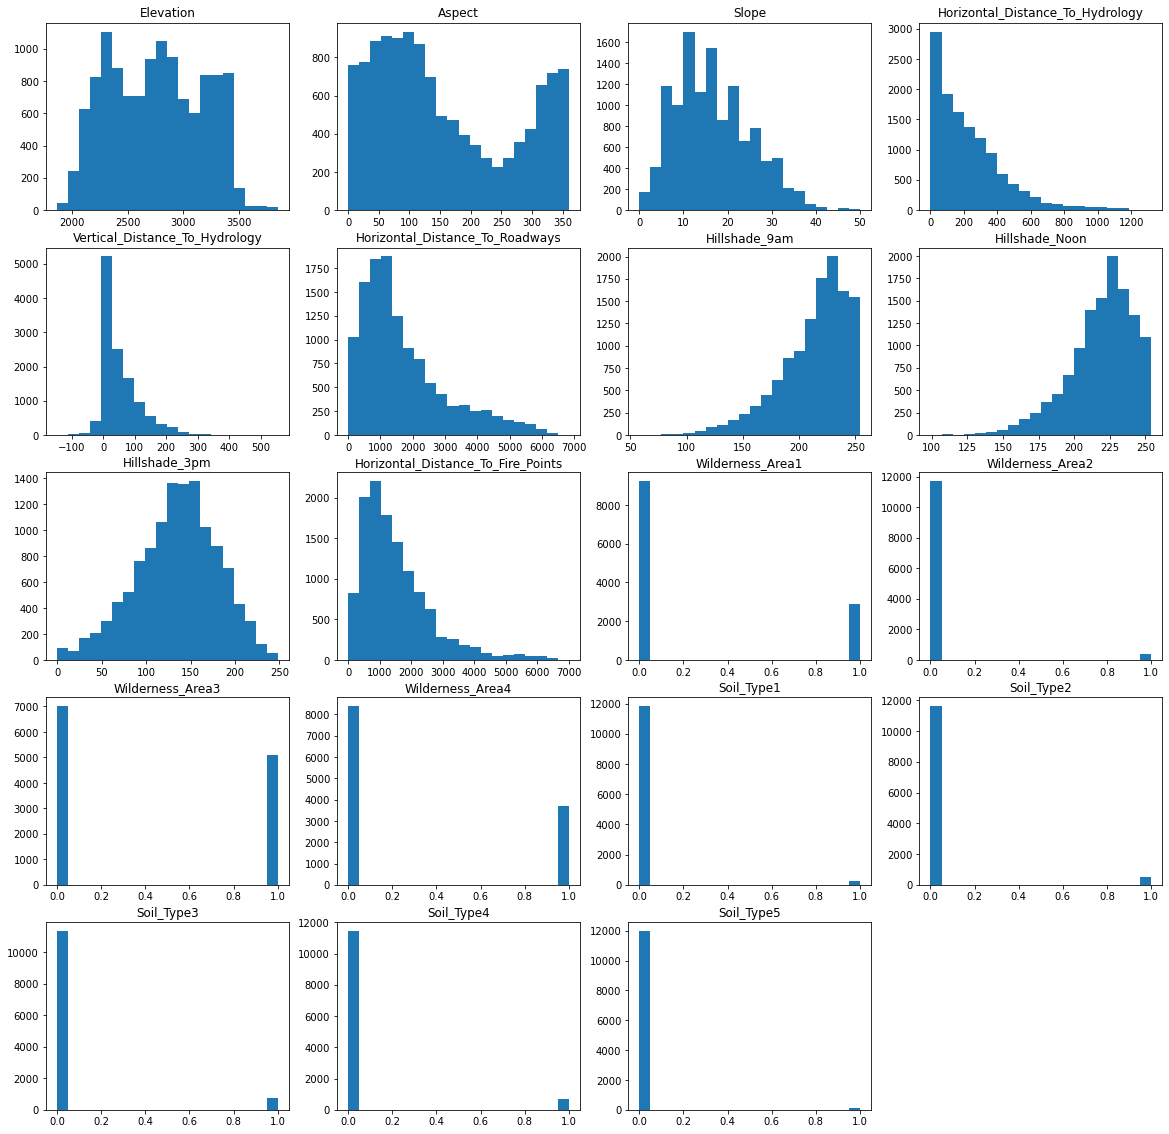

In [4]:
# Create a new figure and set the figsize argument so we get square-ish plots of the 4 features.
plt.figure(figsize=(20, 20))

feature_cols = train_df.columns.tolist()

# Iterate over the features, creating a subplot with a histogram for each one.
for feature in range(1, 20): #train_data.shape[1]
    plt.subplot(5, 4, feature)
    plt.hist(train_data[:,feature], 20)
    plt.title(feature_cols[feature])

The variables outside of the wilderness and soil binary flags all have a generally nice distribution generally spread across their respective ranges. We anticipate the wilderness and soil variables to be relatively sparse and likely good candidates for dimensionality reduction.

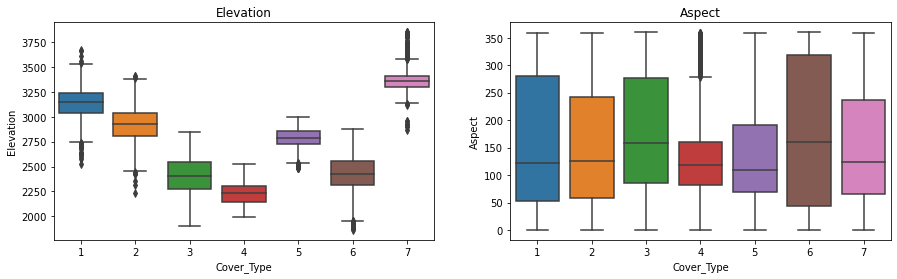

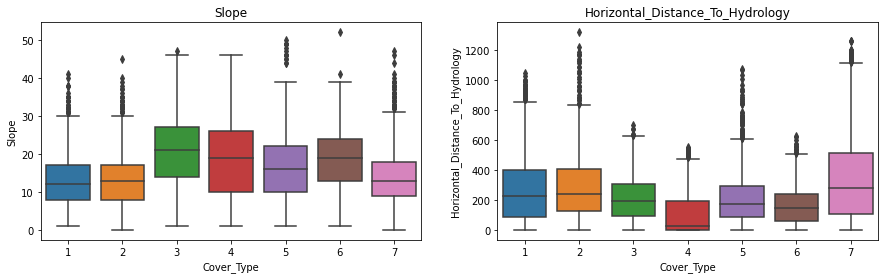

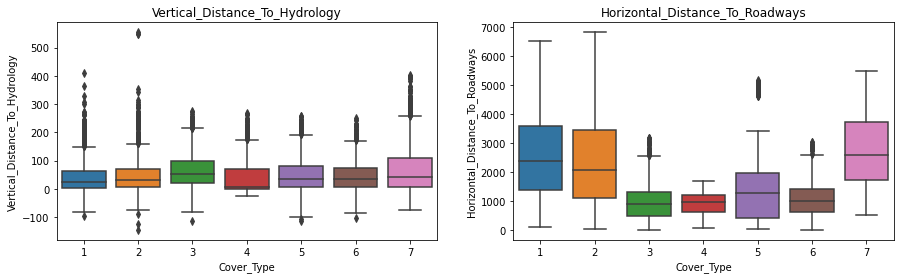

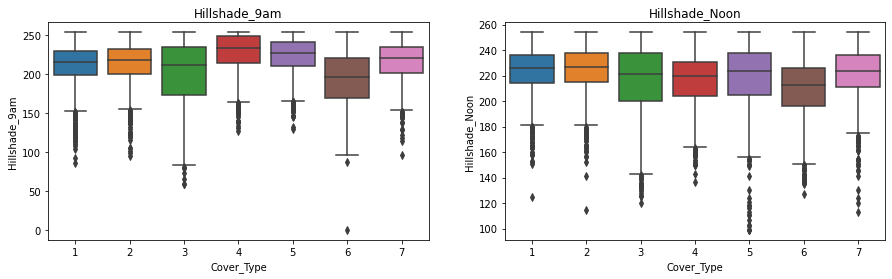

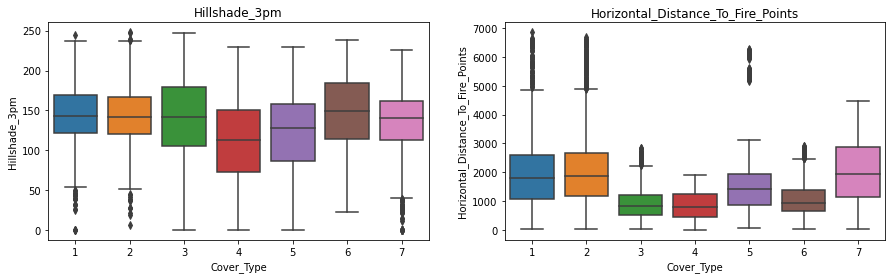

In [5]:
# plot boxplots of each cover type across first 10 feature values (excluding wilderness and soil type binary columns)

# columns to plot (2 columns plotted per row)
column_pairs_to_plot = [['Elevation','Aspect'],
                        ['Slope','Horizontal_Distance_To_Hydrology'],
                        ['Vertical_Distance_To_Hydrology','Horizontal_Distance_To_Roadways'],
                        ['Hillshade_9am','Hillshade_Noon'],
                        ['Hillshade_3pm','Horizontal_Distance_To_Fire_Points']]

# plot each boxplot
for column_pair in column_pairs_to_plot:
    
    fig, axs = plt.subplots(ncols = 2, figsize=(15, 4))
    
    column_1 = column_pair[0]
    column_2 = column_pair[1]
    
    sns.boxplot(x='Cover_Type', y=column_1, data=train_df, ax = axs[0])
    axs[0].set_title(column_1)
    
    sns.boxplot(x='Cover_Type', y=column_2, data=train_df, ax = axs[1])
    axs[1].set_title(column_2)
    plt.show()

At first glance, elevation variable has the most variability across cover types. Some cover type pairs emerge with similar characteristics. For example, cover type 1 & 2 seem to have similar thresholds in addition cover types 3 & 4. 

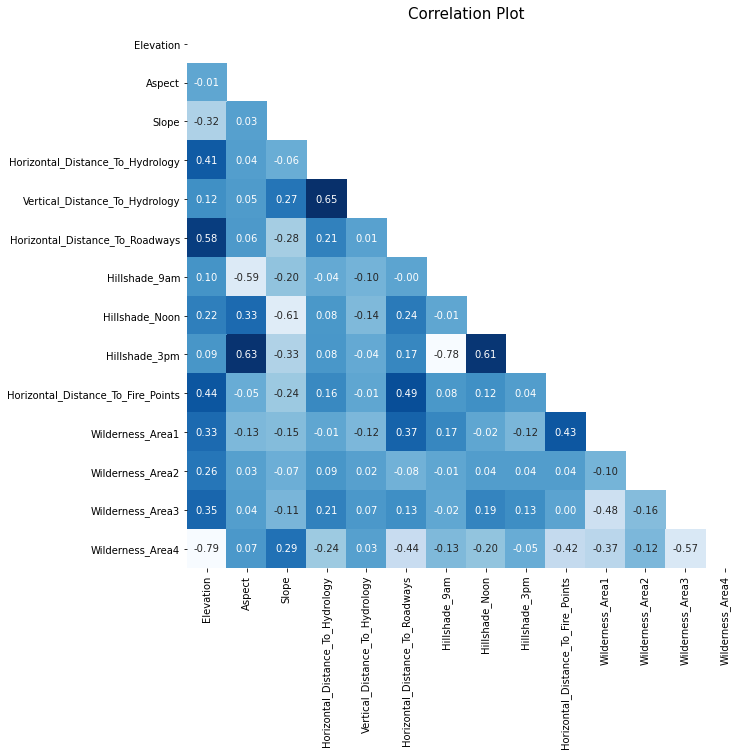

In [6]:
# correlation plot
corr = train_df.iloc[:, 1:15].corr()

# make mask (only plot lower left triangle)
mask = np.ones_like(corr,dtype = np.bool)
mask = np.triu(mask)

# plot the heatmap
fig, ax = plt.subplots(figsize=(10,10))         
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        mask = mask,
        annot=True, 
        fmt='.2f',
        cmap="Blues",
        cbar=False)

plt.title('Correlation Plot',size=15)
plt.show()
pass

No extreme intercorellation among features, but several coefficients with an absolute value above 0.5. There might be a benefit to use dimensionality reduction or other types of feature engineering to consolidate the features. 

### Plot Binary Variables

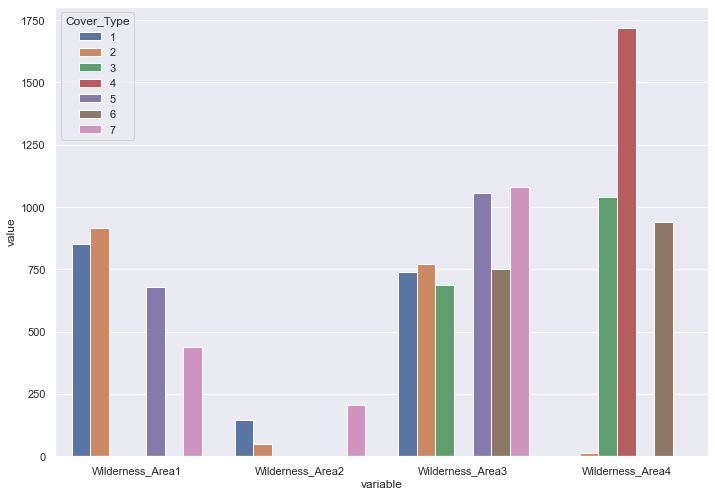

In [7]:
# sumarize counts per wilderness flag per cover type  

# get wilderness columns
wild_cols = [col for col in train_df.columns if 'Wilderness' in col]
wild_cols += ['Cover_Type']

# summarize wilderness column counts by cover type
wilderness_cover_type = train_df[wild_cols].groupby(['Cover_Type']).sum()
wilderness_cover_type = wilderness_cover_type.reset_index()

# make table longer for easier plotting
wilderness_cover_type = pd.melt(wilderness_cover_type, id_vars=['Cover_Type'])

# Plot wilderness counts
sns.set(rc={'figure.figsize':(11.7,8.27)})   
sns.barplot(x='variable', y='value', hue="Cover_Type", data=wilderness_cover_type)
plt.show()

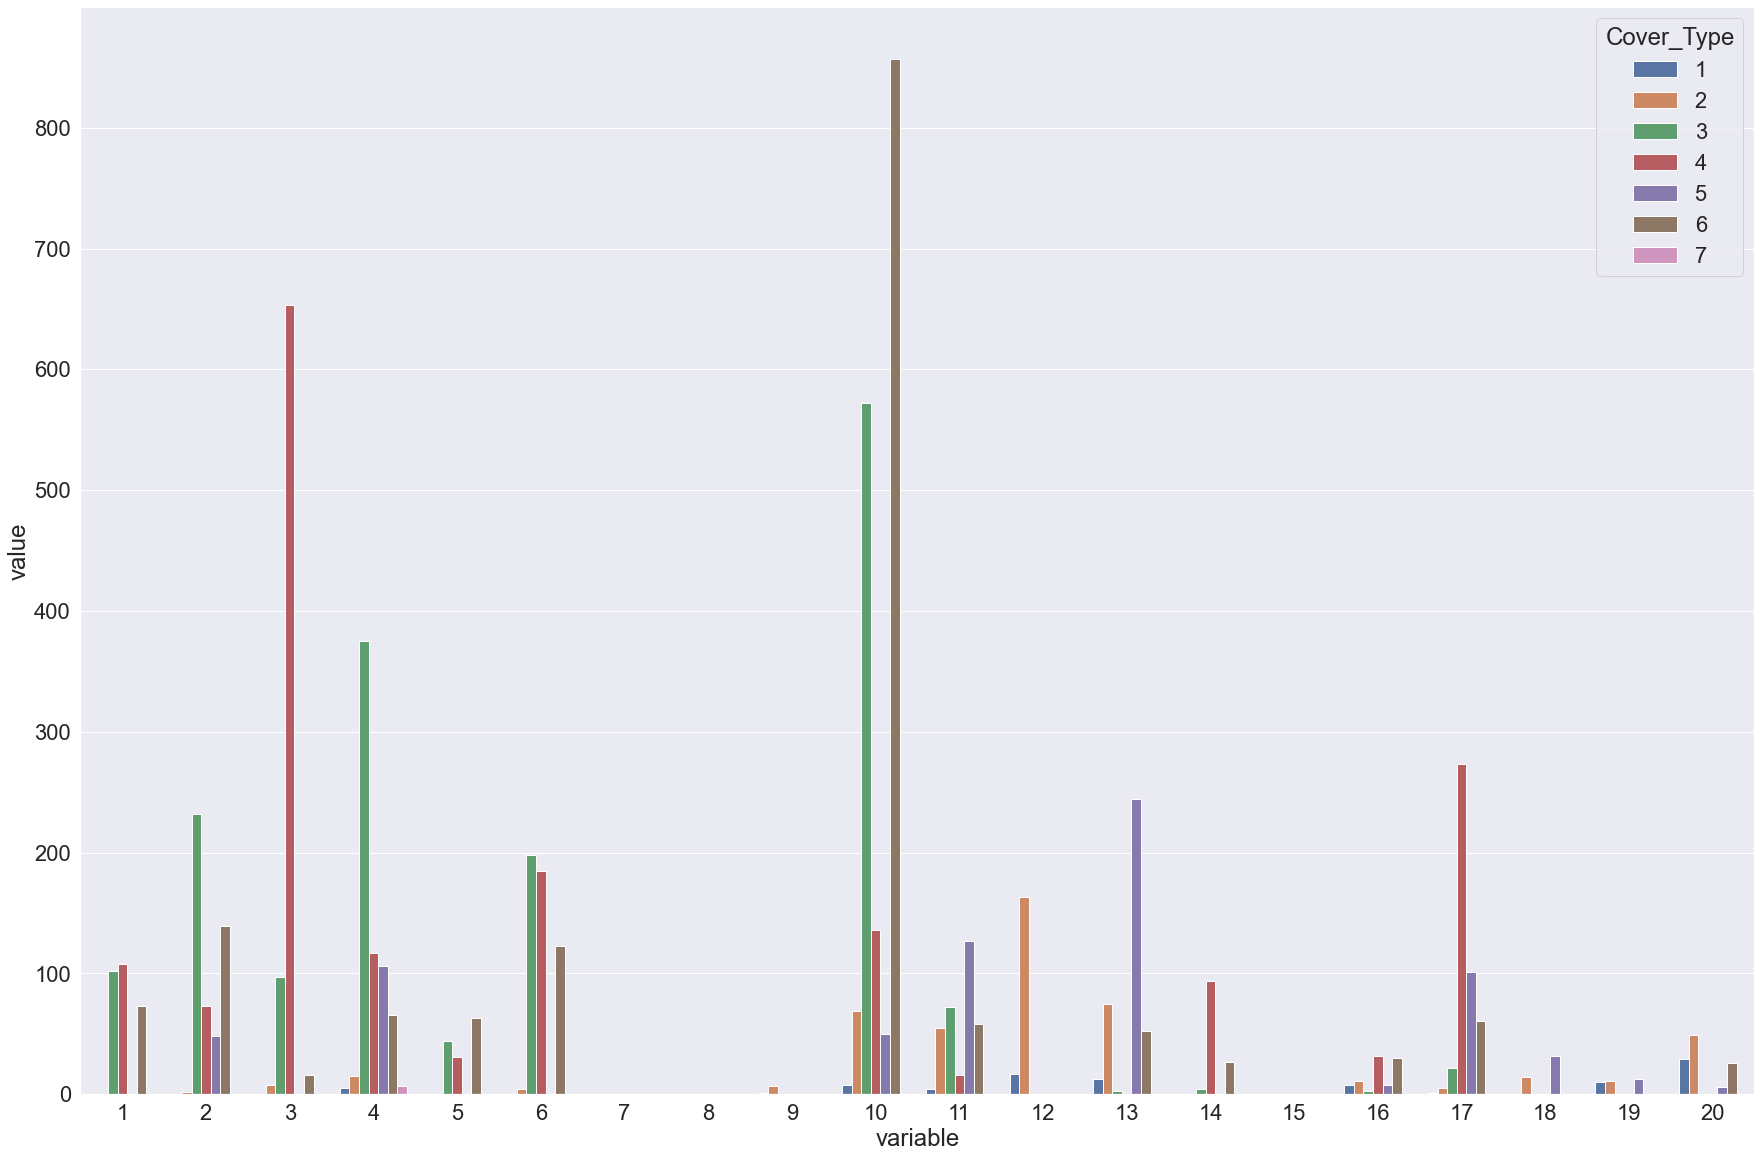

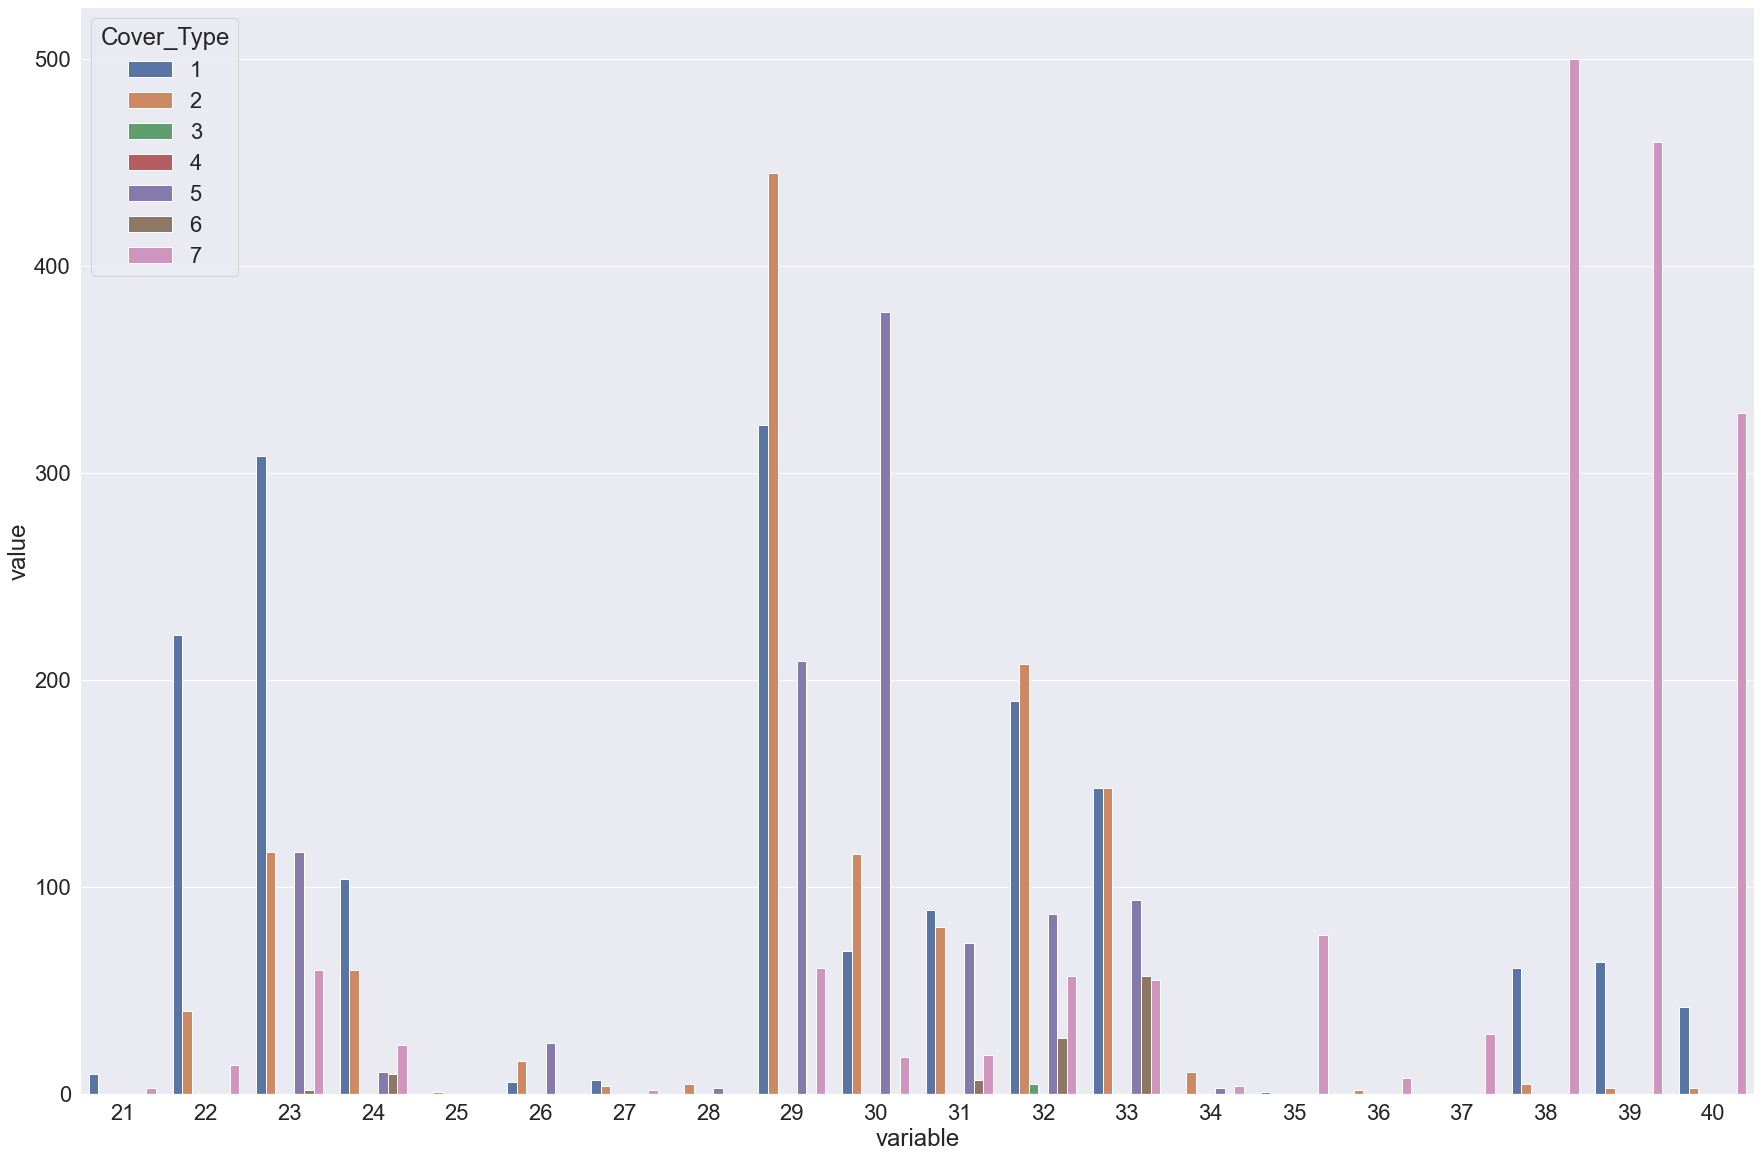

In [35]:
# sumarize counts per soil flag per cover type  

# get soil columns
soil_cols = [col for col in train_df.columns if 'Soil' in col]
soil_cols += ['Cover_Type']

# summarize wilderness column counts by cover type
soil_cover_type = train_df[soil_cols].groupby(['Cover_Type']).sum()
soil_cover_type = soil_cover_type.reset_index()

# make long format
soil_cover_type = pd.melt(soil_cover_type, id_vars=['Cover_Type'])

# remove text from soil_type and extract integer value
soil_cover_type['variable'] = soil_cover_type['variable'].str.extract('(\d+)').astype(int)

soil_cover_type_1 = soil_cover_type[soil_cover_type['variable'] <= 20]
soil_cover_type_2 = soil_cover_type[soil_cover_type['variable'] > 20]


# plotting; separate in 2 due to high number of columns
# plot 1
sns.set(rc={'figure.figsize':(30,20)}, font_scale = 2)  
sns.barplot(x='variable', y='value', hue="Cover_Type", data=soil_cover_type_1)
plt.show()

# plot 2
sns.barplot(x='variable', y='value', hue="Cover_Type", data=soil_cover_type_2)
plt.show()

The frequency counts highlight the sparsity of the binary flags, but also show some patterns where certain cover types are concentrated across specific ones. For instance, wilderness area 4 is primarily cover type 4. Another example is how cover type 7 largely has soil types 36-40. 

# 3) Baseline Models

We initially tested 6 different classifiers. For each we fit the model on the `train_data` and generalized on the `dev_data`. The `test_data` from the kaggle website doesn't contain any class labels.

Classifiers we used include;
- K-nn
- Logistic Regression
- Naive Bayes (Bernoulli & Gaussian)
- Random Forrest
- Extra Trees

Model,Accuracy
Knn,80.456349
Logistic Regression,37.996032
Bernoulli Naive Bayes,60.052910
Gaussian Naive Bayes,64.748677
Random Forest,86.011905
Extra Trees,86.441799



K-Nearest Neighbors Confusion Matrix


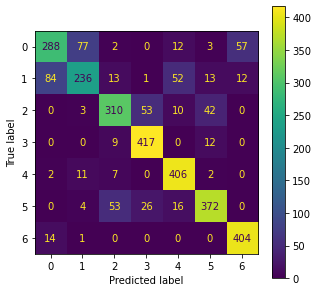

Logistic Regression Confusion Matrix


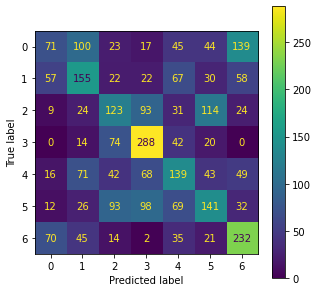

Bernoulli Naive Bayes Confusion Matrix


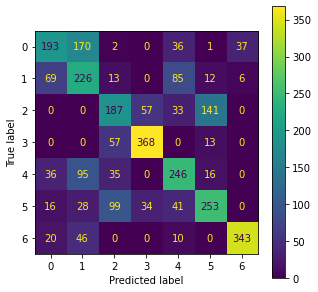

Gaussian Naive Bayes Confusion Matrix


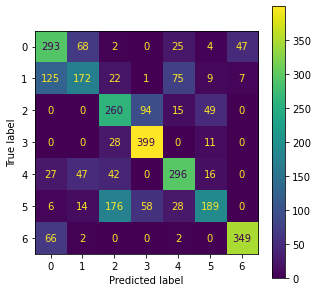

Random Forrest Confusion Matrix


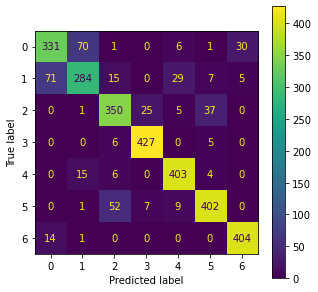

Extra Trees Confusion Matrix


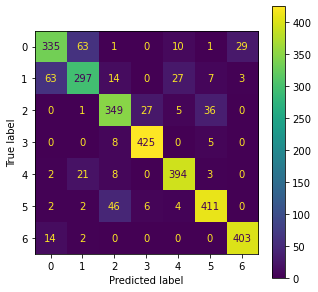

In [3]:
def plot_confusion_matrix(dev_labels, pred_labels):
    #print(f'cover type 1 and type 2 total correct {np.sum(np.diag(metrics.confusion_matrix(dev_labels, pred_labels))[:2])}')

    cm = confusion_matrix(dev_labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots(figsize=(5,5))
    disp = disp.plot(include_values=True, cmap='viridis', ax=ax, xticks_rotation='horizontal')    
    plt.grid(False)
    plt.show()
    return

def baseline_models(
    train_data=train_data, 
    train_labels=train_labels, 
    dev_data=dev_data, 
    dev_labels=dev_labels,
    show_confusion_matrix=True,
    show_accuracy_dataframe=True):
    import warnings
    warnings.filterwarnings("ignore")

    # K-Nearest Neighbors
    knn = KNeighborsClassifier()
    knn.fit(train_data, train_labels)
    accuracy_knn = (knn.score(dev_data, dev_labels)*100)
    pred_labels_knn  = knn.predict(dev_data)

    # Logistic Regression
    lm = LogisticRegression() 
    lm.fit(train_data, train_labels)
    accuracy_lr = (lm.score(dev_data, dev_labels)*100)
    pred_labels_lr  = lm.predict(dev_data)
        
    # Bernoulii Naive Bayes
    bnb = BernoulliNB()
    bnb.fit(train_data, train_labels)
    accuracy_bnb = (bnb.score(dev_data, dev_labels)*100)
    pred_labels_bnb  = bnb.predict(dev_data)
        
    # Gaussian Naive Bayes
    gnb = GaussianNB()
    gnb.fit(train_data, train_labels)
    accuracy_gnb = (gnb.score(dev_data, dev_labels)*100)
    pred_labels_gnb  = gnb.predict(dev_data)

    # Random Forest
    rf = RandomForestClassifier(random_state=0)
    rf.fit(train_data, train_labels)
    accuracy_rf = (rf.score(dev_data, dev_labels)*100)
    pred_labels_rf  = rf.predict(dev_data)
    predictions_posterior_rf = rf.predict_proba(dev_data)

    # ExtraTrees
    et = ExtraTreesClassifier(random_state=0)
    et.fit(train_data, train_labels)
    accuracy_et = (et.score(dev_data, dev_labels)*100)
    pred_labels_et  = et.predict(dev_data)
    predictions_posterior_et = et.predict_proba(dev_data)
    
    # make dataframe with accuracies
    accuracies = {
        'Model' : ['Knn','Logistic Regression', 'Bernoulli Naive Bayes', 'Gaussian Naive Bayes' ,'Random Forest','Extra Trees'],
        'Accuracy' : [accuracy_knn, accuracy_lr, accuracy_bnb, accuracy_gnb, accuracy_rf, accuracy_et]
    }
    accuracies = pd.DataFrame(accuracies)
    
    if show_accuracy_dataframe:
        display(accuracies.style.set_table_attributes('style="font-size: 17px"').hide_index())
    
    if show_confusion_matrix:
        print('\nK-Nearest Neighbors Confusion Matrix')
        plot_confusion_matrix(dev_labels, pred_labels_knn)
        print('Logistic Regression Confusion Matrix')
        plot_confusion_matrix(dev_labels, pred_labels_lr)
        print('Bernoulli Naive Bayes Confusion Matrix')
        plot_confusion_matrix(dev_labels, pred_labels_bnb)
        print('Gaussian Naive Bayes Confusion Matrix')
        plot_confusion_matrix(dev_labels, pred_labels_gnb)
        print('Random Forrest Confusion Matrix')
        plot_confusion_matrix(dev_labels, pred_labels_rf)
        print('Extra Trees Confusion Matrix')
        plot_confusion_matrix(dev_labels, pred_labels_et)
    
    return accuracies

baseline_accuracies = baseline_models()

### Accuracy Comparison

The baseline models performed fairly well with accuracies as high as 86%. We chose accuracy as our performance metric because we did not have any reason to believe whether a false positive or false negative is more meaninful for the business problem. There also is an even proportion of class types within the data set so we do not believe the accuracy will be misleading by simply predicting the majority class each time.

Notably, there is a large variance across model accuracy with the worst classifer, logistic regression, reporting an accuracy of 38%. We believe this shows the non-linear nature of the data and how different cover types vary. Naive bayes performs better, with an accuracy of 60-65% but probably performs worse given the naive independence of feature assumption. Knn, Random Forest, & Extra Trees perform the best with accuracies of 80-86%. We hypothesize they perform better as they can model complex non-linear relationships. Random forest & extra trees might be performing better because of the high number of features (~50).

### Error Analysis

The confusion matrix shows two pairs of commonly confused classes. Classes 0 & 1 as well as classes 2 & 5 seem to be getting mixed up the most. Looking at the boxplots above we can see those pairs are very similar across the features which is likely why the model is getting confused. We plan to tweak our model in a way to try and improve classification across these classes.

### Next Steps

Given the performance of the baseline models we plan to prioritize optimization on the knn, random forrest, and extra trees classifiers. We still plan to check how various optimization strategies improve upon performance of logistic regression and naive bayes classifiers. We plan to approach model optimization across three sections;

1.  Feature selection/engineering
    + None of our team members have any domain knowledge on the space. We expect that there is an opportunity to build new features using a combination of the existing ones, but will prioritize our time elsewhere. 
    + Dimensionality reduction: We will focus on trying to reduce the number of features (using PCA). The binary flags for wilderness and soil are notably sparse which play a big motivating factor of why we want to test this approach.
    

2. Ensemble methods
    + We will test building a stage based ensemble of models that tries to improve upon commonly confused classes (noted in the error analysis section). The first model will act similar to the baseline models, but if the first model predicts one of the confused classes we will use a subsequent model. The subsequent model will be trained on solely the confused classes in a hope to better fit the subtle differences among those. For example, the subsequent model will be only trained on classes 0 & 1 and will only be used if the first model predicts a 0 or 1. 
    + Random forest and extra trees are by nature ensemble based classifiers. They already have the best performance which we think can be partially a result of their nature of combining multiple models. We will try and use the predict_proba methods and test different permutations of ensumbles across the clasffiers and use the predition from the model that is the most confident. 

    
3. Hyperparameters
    + We plan to test various hyperparamters across the classifiers using a grid search cross validation to see if reducing complexity will improve accuracy during the generalize step.

# 4) Generalize Step Optimization

### Feature Selection/Engineering

pca on soil_types

In [18]:
# get feature indexes for Soil_Types
other_idx = [i for i, col in enumerate(train.columns) if not 'Soil' in col and 'Cover' not in col]
soil_type_idx = [i for i, col in enumerate(train.columns) if 'Soil' in col]

soil_type_features = train_data[:, soil_type_idx]
other_features = train_data[:, other_idx]

In [19]:
# a handy function for vizualizing principle components as a heatmap
# this allows you to see what dimensions in the 'original space' are
# active

def visualize_pca_comps_heatmap(plot, comps, alpha=None):
    heatmap = plot.pcolor(comps, cmap=plt.cm.Blues)
    

    x_lab = [i for i in range(comps.shape[1])]
    y_lab = [i for i in (range(comps.shape[0]))]
    
    plot.set_xticks(np.arange(comps.shape[1])+0.5, minor=False)
    plot.set_yticks(np.arange(comps.shape[0])+0.5, minor=False)
    
    # want a more natural, table-like display
    plot.invert_yaxis()
    
    plot.set_xticklabels(x_lab, minor=False)
    plot.set_yticklabels(y_lab, minor=False)
    
    if alpha is not None:
        plt.title(f'Heatmap of Sparse PCA (alpha {alpha}) components Rows: components, Cols: Original dimensions. ')
    else:
        plt.title('Heatmap of PCA components Rows: components, Cols: Original dimensions')

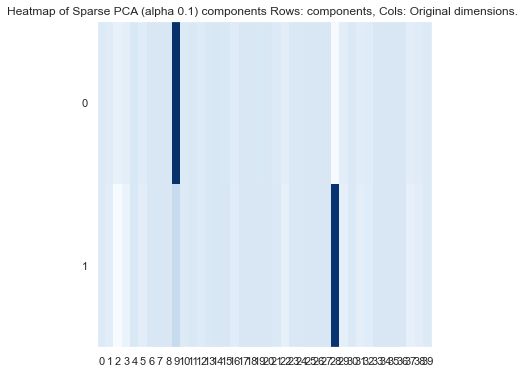

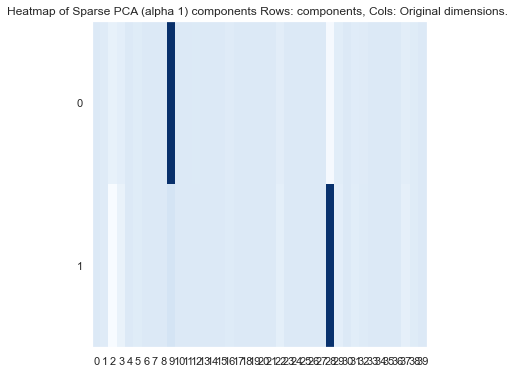

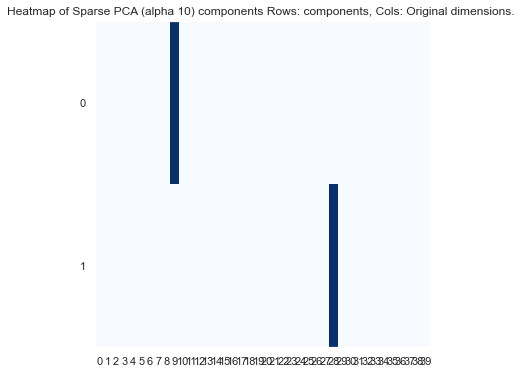

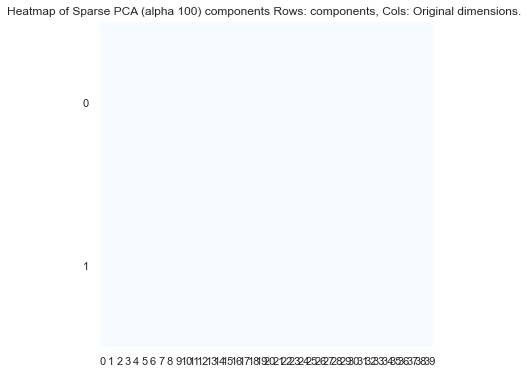

In [20]:
def pca_testing():
    # change alpha and watch as dimensions get dropped
    n_comp = 2
    
    ###############
    plt.figure(figsize=(6, 6))
    alpha_set = 0.1
    spca = SparsePCA(n_components = n_comp, alpha=alpha_set, tol=0.1) # always done now, depreciated #, normalize_components=True)
    spca.fit(soil_type_features)
    p2 = plt.subplot(1, 1, 1)
    visualize_pca_comps_heatmap(p2, spca.components_, alpha_set)
    ###############

    ###############
    plt.figure(figsize=(6, 6))
    alpha_set = 1
    spca = SparsePCA(n_components = n_comp, alpha=alpha_set, tol=0.1) # always done now, depreciated #, normalize_components=True)
    spca.fit(soil_type_features)
    p2 = plt.subplot(1, 1, 1)
    visualize_pca_comps_heatmap(p2, spca.components_, alpha_set)
    ###############

    ###############
    plt.figure(figsize=(6, 6))
    alpha_set = 10
    spca = SparsePCA(n_components = n_comp, alpha=alpha_set, tol=0.1) # always done now, depreciated #, normalize_components=True)
    spca.fit(soil_type_features)
    p2 = plt.subplot(1, 1, 1)
    visualize_pca_comps_heatmap(p2, spca.components_, alpha_set)
    ###############

    ###############
    plt.figure(figsize=(6, 6))
    alpha_set = 100
    spca = SparsePCA(n_components = n_comp, alpha=alpha_set, tol=0.1) # always done now, depreciated #, normalize_components=True)
    spca.fit(soil_type_features)
    p2 = plt.subplot(1, 1, 1)
    visualize_pca_comps_heatmap(p2, spca.components_, alpha_set)
    ###############

pca_testing()

binarize or trinarize features to reduce complexity?

#### Test PCA & sPCA Code Changes

In [4]:
def split_soil_type_features(dataset):
    # get feature indexes for Soil_Types
    other_idx = [i for i, col in enumerate(train.columns) if not 'Soil' in col and 'Cover' not in col]
    soil_type_idx = [i for i, col in enumerate(train.columns) if 'Soil' in col]
    
    soil_type_features = dataset[:, soil_type_idx]
    other_features = dataset[:, other_idx]
    
    return other_features, soil_type_features

def spca_n_comp_trials(split_features=True):
    
    # initial empty dataframe which will have all different accuracy permutations
    model_accuracy = pd.DataFrame(columns = ['Model','Accuracy','n_components','alpha'])
    
    for alpha_set in [1,10,100]:
        for n_comp in range(1,6):
            #print()
            #print('-'*25)
            #print(f'number of components = {n_comp}. alpha = {alpha_set}')
        
            if split_features == True:
                ##### transform train_data #####
                other_features, soil_type_features = split_soil_type_features(train_data)
                spca = SparsePCA(n_components = n_comp, alpha=alpha_set, tol=0.1) # always done now, depreciated #, normalize_components=True)
                spca_soil_features = spca.fit_transform(soil_type_features)
                spca_transformed_train_data = np.concatenate((other_features, spca_soil_features), axis=1)

                ##### transform dev_data #####
                other_features, soil_type_features = split_soil_type_features(dev_data)
                spca = SparsePCA(n_components = n_comp, alpha=alpha_set, tol=0.1) # always done now, depreciated #, normalize_components=True)
                spca_soil_features = spca.fit_transform(soil_type_features)
                spca_transformed_dev_data = np.concatenate((other_features, spca_soil_features), axis=1)
            else:
                ##### transform train_data #####
                spca = SparsePCA(n_components = n_comp, alpha=alpha_set, tol=0.1) # always done now, depreciated #, normalize_components=True)
                spca_transformed_train_data = spca.fit_transform(train_data)

                ##### transform dev_data #####
                spca = SparsePCA(n_components = n_comp, alpha=alpha_set, tol=0.1) # always done now, depreciated #, normalize_components=True)
                spca_transformed_dev_data = spca.fit_transform(dev_data)
            
            # store accuracies
            accuracies = baseline_models(
                            train_data=spca_transformed_train_data, 
                            train_labels=train_labels, 
                            dev_data=spca_transformed_dev_data,
                            dev_labels=dev_labels,
                            show_confusion_matrix=False,
                            show_accuracy_dataframe=False
                         )
            
            # add into main dataframe to enable visualization of different hyperparams
            accuracies['n_components'] = n_comp
            accuracies['alpha'] = alpha_set
            model_accuracy = model_accuracy.append(accuracies)
            
    return model_accuracy


def pca_n_comp_trials(split_features=True):
    
    # initial empty dataframe which will have all different accuracy permutations
    model_accuracy = pd.DataFrame(columns = ['Model','Accuracy','n_components'])
    
    for n_comp in range(1,6):
        #print()
        #print('-'*25)
        #print(f'number of components = {n_comp}')

        if split_features == True:
            ##### transform train_data #####
            other_features, soil_type_features = split_soil_type_features(train_data)
            pca = PCA(n_components = n_comp) # always done now, depreciated #, normalize_components=True)
            pca_soil_features = pca.fit_transform(soil_type_features)
            pca_transformed_train_data = np.concatenate((other_features, pca_soil_features), axis=1)

            ##### transform dev_data #####
            other_features, soil_type_features = split_soil_type_features(dev_data)
            pca = PCA(n_components = n_comp) # always done now, depreciated #, normalize_components=True)
            pca_soil_features = pca.fit_transform(soil_type_features)
            pca_transformed_dev_data = np.concatenate((other_features, pca_soil_features), axis=1)
        else:
            ##### transform train_data #####
            pca = PCA(n_components = n_comp) # always done now, depreciated #, normalize_components=True)
            pca_transformed_train_data = pca.fit_transform(train_data)

            ##### transform dev_data #####
            pca = PCA(n_components = n_comp) # always done now, depreciated #, normalize_components=True)
            pca_transformed_dev_data = pca.fit_transform(dev_data)

        
        # store accuracies
        accuracies = baseline_models(
                        train_data=pca_transformed_train_data, 
                        train_labels=train_labels, 
                        dev_data=pca_transformed_dev_data,
                        dev_labels=dev_labels,
                        show_confusion_matrix=False,
                        show_accuracy_dataframe=False
                     )

        # add into main dataframe to enable visualization of different hyperparams
        accuracies['n_components'] = n_comp
        model_accuracy = model_accuracy.append(accuracies)
            
    return model_accuracy

In [5]:
# spca
model_accuracy_spca_split = spca_n_comp_trials(split_features=True)
model_accuracy_spca       = spca_n_comp_trials(split_features=False)

# pca
model_accuracy_pca_split = pca_n_comp_trials(split_features=True)
model_accuracy_pca       = pca_n_comp_trials(split_features=False)

In [39]:
# combine dataframes into one to summarize metrics

baseline_accuracies['Method'] = 'Baseline'
model_accuracy_spca_split['Method'] = 'Sparse PCA on Soil Features'
model_accuracy_spca['Method'] = 'Sparse PCA on All Features'
model_accuracy_pca_split['Method'] = 'PCA on Soil Features'
model_accuracy_pca['Method'] = 'PCA on All Features'

columns = ['Model','Method','Accuracy']
model_accuracy_all = pd.concat([baseline_accuracies,
                                model_accuracy_spca_split,
                                model_accuracy_spca,
                                model_accuracy_pca_split,
                                model_accuracy_pca])
model_accuracy_all = model_accuracy_all[columns]

In [40]:
model_accuracy_all.groupby(['Model']).describe()

Accuracy                                              \
                         count       mean        std        min        25%   
Model                                                                        
Bernoulli Naive Bayes     41.0  30.965286   8.694442  17.824074  23.148148   
Extra Trees               41.0  68.677410  18.376173  27.215608  61.673280   
Gaussian Naive Bayes      41.0  48.916796  13.357287  26.124339  33.432540   
Knn                       41.0  69.054878  17.098664  29.398148  61.739418   
Logistic Regression       41.0  35.710253   7.421040  17.791005  30.357143   
Random Forest             41.0  68.757259  18.331564  27.215608  59.457672   

                                                        
                             50%        75%        max  
Model                                                   
Bernoulli Naive Bayes  28.802910  38.392857  60.052910  
Extra Trees            74.503968  82.010582  86.441799  
Gaussian Naive Bayes   57.969577  59.424603  64.748677  
Knn                    80.456349  80.456349  80.456349  
Logistic Regression    38.293651  38.624339  45.238095  
Random Forest          76.587302  83.234127  86.011905

In [41]:
model_accuracy_all.groupby(['Method']).describe()

Accuracy                                   \
                               count       mean        std        min   
Method                                                                  
Baseline                         6.0  69.284612  18.887845  37.996032   
PCA on All Features             30.0  45.327381  18.841843  17.791005   
PCA on Soil Features            30.0  64.765212  19.670086  38.326720   
Sparse PCA on All Features      90.0  45.342813  18.562294  17.791005   
Sparse PCA on Soil Features     90.0  60.066872  22.090717  17.824074   

                                                                         
                                   25%        50%        75%        max  
Method                                                                   
Baseline                     61.226852  72.602513  84.623016  86.441799  
PCA on All Features          29.679233  43.253968  61.251653  79.530423  
PCA on Soil Features         40.476190  71.494709  81.572421  86.144180  
Sparse PCA on All Features   29.588294  43.452381  61.144180  80.224868  
Sparse PCA on Soil Features  38.318452  61.739418  80.456349  85.548942

### Hyperparameters

### Ensemble Methods

fit accuracy: 0.8687170437890119
best parameters:
{'criterion': 'gini', 'max_depth': 500, 'max_features': 'auto', 'n_estimators': 200}
generalize accuracy: 0.8591269841269841


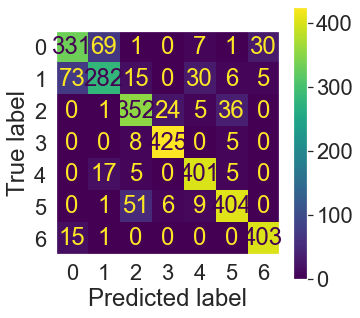

Wall time: 12h 23min 22s


In [39]:
%%time

def rf_search(train_data=train_data, 
    train_labels=train_labels, 
    dev_data=dev_data, 
    dev_labels=dev_labels):
    parameters = {
        'n_estimators': [100, 200],#list(range(100,500,100)),
        'max_features': ['auto', None, 'log2'],
        'max_depth' : list(range(500,700,100)),
        'criterion' :['entropy', 'gini'], #'entropy', 
    }

    rf = RandomForestClassifier(random_state=0)

    rf_gs = GridSearchCV(rf, parameters, n_jobs=-1, scoring='accuracy').fit(train_data, train_labels)

    print(f'fit accuracy: {rf_gs.best_score_}')
    print(f'best parameters:\n{rf_gs.best_params_}')

    rf_pred = rf_gs.best_estimator_.predict(dev_data).astype(int)

    ###generate accuracy
    accuracy_count = 0
    for j in range(dev_labels.shape[0]):
        if rf_pred[j] == dev_labels[j]:
            accuracy_count += 1
        else:
            continue

    print(f'generalize accuracy: {accuracy_count/rf_pred.shape[0]}')


    plot_confusion_matrix(dev_labels, rf_pred)

rf_search()


Random Forest accuracy = 86.01190476190477
cover type 1 and type 2 total correct 615


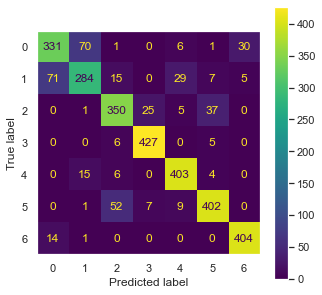

cover type 1 and type 2 total correct 615
K-Nearest Neighbors accuracy = 73.60406091370558
cover type 1 and type 2 total correct 580


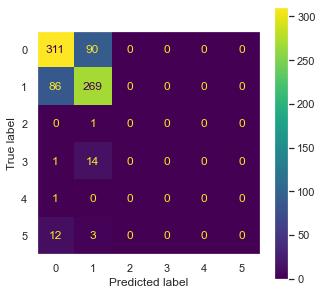


Logistic Regression accuracy = 69.28934010152284
cover type 1 and type 2 total correct 546


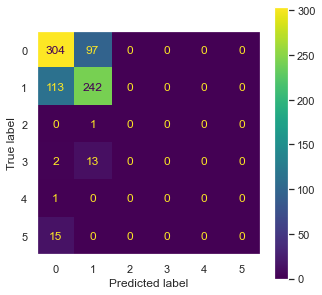


Gaussian Naive Bayes accuracy = 68.1472081218274
cover type 1 and type 2 total correct 537


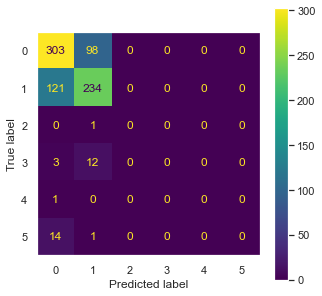


Random Forest accuracy = 77.41116751269035
cover type 1 and type 2 total correct 610


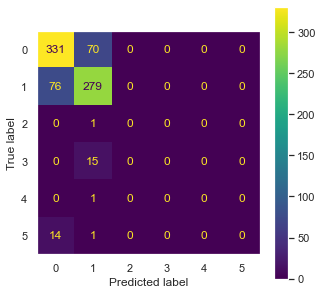

[[1.  0. ]
 [1.  0. ]
 [0.6 0.4]
 ...
 [0.8 0.2]
 [0.  1. ]
 [0.8 0.2]]

Extra Trees accuracy = 79.06091370558376
cover type 1 and type 2 total correct 623


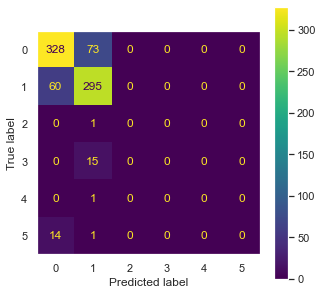

[[1.  0. ]
 [1.  0. ]
 [0.6 0.4]
 ...
 [0.8 0.2]
 [0.  1. ]
 [0.8 0.2]]


In [34]:
def random_forest(train_data=train_data, 
    train_labels=train_labels, 
    dev_data=dev_data, 
    dev_labels=dev_labels,
    show_confusion_matrix=True):
    # Random Forest
    rf = RandomForestClassifier(random_state=0)
    rf.fit(train_data, train_labels)
    print(f'\nRandom Forest accuracy = {(rf.score(dev_data, dev_labels)*100)}')
    pred_labels  = rf.predict(dev_data)
    if show_confusion_matrix == True:
        plot_confusion_matrix(dev_labels, pred_labels)
        
    print(f'cover type 1 and type 2 total correct {np.sum(np.diag(metrics.confusion_matrix(dev_labels, pred_labels))[:2])}')
        
    #     ########## just type 1 and 2 ##########
    train_data_1_2 = train_data[(train_labels == 1) | (train_labels == 2)]
    train_labels_1_2 = train_labels[(train_labels == 1) | (train_labels == 2)]
    pred_knn_1_2_data = dev_data[(pred_labels == 1) | (pred_labels == 2)]
    pred_knn_1_2_actual_labels = dev_labels[(pred_labels == 1) | (pred_labels == 2)]
    
    
    
    
    baseline_models(train_data_1_2, train_labels_1_2, pred_knn_1_2_data, pred_knn_1_2_actual_labels)
    
        
random_forest()

# 5) Conclusion

# 6) Appendix

- Git repository [[link](https://github.com/sams-data/mids-w207_9_sp22_forest_cover_classification/blob/main/README.md)]